# Confounder Bias

Confounders are variables that influence both the treatment and the outcome. If we forget to include a confounder in our model, our estimate of the treatment effect will suffer from bias. In this notebook I will demonstrate confounder bias by means of a simple synthetic example.

In [88]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from causalgraphicalmodels import CausalGraphicalModel
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
style.use("fivethirtyeight")

# Sample data
np.random.seed(0)
money = np.random.normal(loc=100, scale=5, size=200)
tablet = np.random.binomial(n=1, p=1/(1+np.exp(100-money)), size=200) 
score = 2 * money + np.random.normal(scale=5, size=200)

Let's assume that we want to measure the effect of tablet usage in schools on school performance.

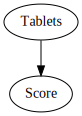

In [78]:
sprinkler = CausalGraphicalModel(
    nodes=["Tablets", "Score"],
    edges=[
        ("Tablets", "Score")
    ]
)

sprinkler.draw()

We start with a univariate analysis and observe that the average score of schools with tablets is 16.39 points higher than the score of schools without tablets.

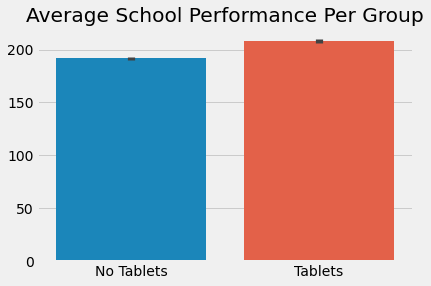

Y[T=1] - Y[T=0] = 16.39


In [89]:
plt.title("Average School Performance Per Group")
sns.barplot(x = tablet, y = score)
plt.xticks([0, 1], ["No Tablets", "Tablets"])
plt.show()

print(f"Y[T=1] - Y[T=0] = {np.mean(score[tablet==1])-np.mean(score[tablet==0]):.2f}")

A regression of school performance on tablet usage implies that this difference is significant.

In [90]:
Y = score
X = sm.add_constant(tablet)
model = sm.OLS(Y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     200.2
Date:                Mon, 15 Nov 2021   Prob (F-statistic):           7.32e-32
Time:                        22:10:41   Log-Likelihood:                -703.36
No. Observations:                 200   AIC:                             1411.
Df Residuals:                     198   BIC:                             1417.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        191.8617      0.827    231.920      0.000     190.230     193.493
x1            16.3891      1.158     14.148      0.000      14.105      18.674
==============================================================================
Omnibus:                        0.291   Durbin-Watson:                   1.874
Prob(Omnibus):                  0.865   Jarque-Bera (JB):                0.303
Skew:                           0.090   Prob(JB):                        0.859
Kurtosis:                       2.938   Cond. No.                         2.64
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

However, we can not conclude from this analysis that tablets cause higher school performance. Why? Because we are missing at least one important variable in our regression equation: money. In our example, the financial funding of schools acts as a confounder variable since it both influences tablet usage (treatment) and school performance (outcome).

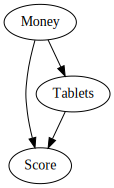

In [91]:
sprinkler = CausalGraphicalModel(
    nodes=["Money", "Tablets", "Score"],
    edges=[
        ("Money", "Tablets"), 
        ("Money", "Score"),
        ("Tablets", "Score")
    ]
)

sprinkler.draw()

Let's plot school performance against both money and tablets.

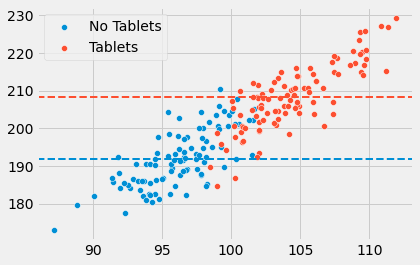

In [92]:
sns.scatterplot(x = money[tablet==0], y = score[tablet==0], label="No Tablets")
sns.scatterplot(x = money[tablet==1], y = score[tablet==1], label="Tablets")
plt.axhline(np.mean(score[tablet==0]), c='C0', lw=2, ls='--')
plt.axhline(np.mean(score[tablet==1]), c='C1', lw=2, ls='--')
plt.show()

What we can see is that money has a positive relationship with both tablet usage and school performance. The performance difference between school with tablets and school without tablets therefore may only be the result of differences in funding. Let's perform another regression of school performance on tablets, now with money as a control variable.

In [93]:
Y = score
X = sm.add_constant(np.c_[tablet, money])
model = sm.OLS(Y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     403.5
Date:                Mon, 15 Nov 2021   Prob (F-statistic):           2.18e-70
Time:                        22:10:50   Log-Likelihood:                -610.37
No. Observations:                 200   AIC:                             1227.
Df Residuals:                     197   BIC:                             1237.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.6725     11.489     -0.668      0.505     -30.330      14.985
x1            -0.5919      1.219     -0.485      0.628      -2.996       1.812
x2             2.0746      0.119     17.385      0.000       1.839       2.310
==============================================================================
Omnibus:                        1.334   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.513   Jarque-Bera (JB):                1.339
Skew:                          -0.195   Prob(JB):                        0.512
Kurtosis:                       2.905   Cond. No.                     3.18e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.18e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Now that we control for money, there is no significant effect of tablet usage on school performance anymore. It seems we almost became victims of confounder bias.